# Experiment on correlation on demodulized signal
This might not be a case if Rtlsdr already demodulate the signal.

In [1]:
4+2 # Test if kernel is running

6

In [2]:
import time
import numpy as  np
import matplotlib.pyplot as plt
import sounddevice as sd
from copy import copy
import math
np.set_printoptions(precision=2)

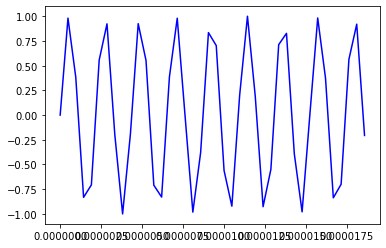

In [3]:
fsps = 2*256*256*16
fc = 1575.42e6
t = np.arange(3000) * 1.0 / fsps
carrier = np.sin(2 * np.pi*fc * t)

plt.plot(t[:40], carrier[:40], 'b')

In [4]:
def LFSR(N, initial, feedback):
    res = np.array([(initial >> (feedback.bit_length()-2)) & 1])
    for i in range(N-1):
        initial <<= 1
        mask = initial & feedback
        for j in range(feedback.bit_length()):
            mask = (mask >> 1) ^ (mask & 1)
        initial = (initial & ((1 << (feedback.bit_length())) -1 ) ) | mask
        res = np.append(res, (initial >> (feedback.bit_length()-2)) & 1)
    return res

In [5]:
G1 = LFSR(1033, 0b1111111111, 0b10000001001)
G2 = LFSR(1033, 0b1111111111, 0b11101001101)

SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

prn = 22 # choose PRN

CA = np.array([])

for i in range(1023):
    CA = np.append (CA, G1[i] ^ G2[i+10-SV[prn][0]] ^ G2[i+10-SV[prn][1]])

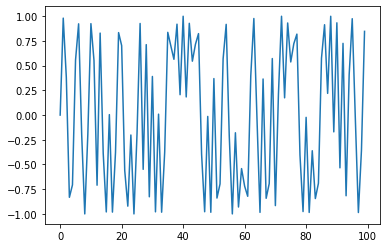

In [6]:
alteredCA = np.zeros(3000)
for i in range(3000):
    T = t[i]
    index = math.floor(T*1000*1023)
    if (index >= 1023):
        break
    elif (CA[index] == 0):
        alteredCA[i] = -1
    else:
        alteredCA[i] = 1
alteredCA = alteredCA[:i]
CAsignal = np.multiply(alteredCA, carrier[:alteredCA.shape[0]])
plt.plot(range(100),np.real(CAsignal[:100]))
CAsignal_n = CAsignal / np.sqrt(np.dot(CAsignal, CAsignal))

In [7]:
np.dot(CAsignal_n, CAsignal_n)

1.0000000000000007

# Test correlation with pure signal.

1.2218963831867057e-08
1.0000000000000007
Probability for signal to get pass threashold 0.5
0.04625
Probability to detect signal with threashold 0.5
0.1725567759741211


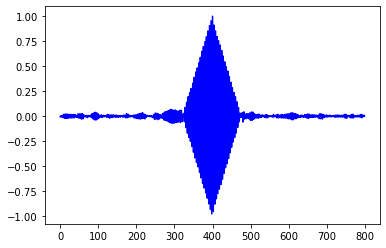

In [8]:
N = 400 # number of sample
#unit = t[1] / N
unit = 1/ (1000*1023) / N *5 # dt
print(unit)
shiftCorrelate = np.zeros(N * 2)
for i in range (N * 2):
    shift = (i-N)*unit
    shiftCA = np.zeros(CAsignal.shape[0])
    for j in range(CAsignal.shape[0]):
        T = t[j]+shift
        index = (math.floor(T*1000*1023) + 1023 * 2) % 1023
        if (CA[index] == 0):
            shiftCA[j] = -1
        else:
            shiftCA[j] = 1
    CAShiftsignal = np.multiply(shiftCA, np.sin(2 * np.pi*fc * (t[:CAsignal.shape[0]] + shift)))
    CAShiftsignal_n = CAShiftsignal / np.sqrt(np.dot(CAShiftsignal, CAShiftsignal))
    shiftCorrelate[i] = np.dot(CAsignal_n, CAShiftsignal_n)
plt.plot(range(N*2), shiftCorrelate, 'b')
print(shiftCorrelate[N])
count = 0
threashold = 0.5 # cutoff threashold
for i in range (N * 2):
    if (abs(shiftCorrelate[i])>=threashold ):
        count+=1
print("Probability for signal to get pass threashold " + str(threashold) )
print((count / (N * 2)))
print("Probability to detect signal with threashold " + str(threashold) )
print(1-(1-(count / (N * 2)))**4)

# Test correlation with signal with noise.

5
4.887585532746823e-09
0.2174925959796188
Probability for signal to get pass threashold 0.1
0.2875
Probability to detect signal with threashold 0.1
0.7422851318359375


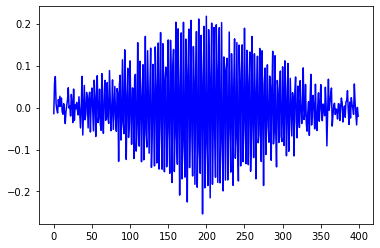

In [10]:
N = 200 # number of sample
noise_level = 5 # maximum noise amplitude relative to signal amplitude
print(noise_level)
#unit = t[1] / N
unit = 1/ (1000*1023) / N # dt
print(unit)
shiftCorrelate = np.zeros(N * 2)
for i in range (N * 2):
    shift = (i-N)*unit
    shiftCA = np.zeros(CAsignal.shape[0])
    for j in range(CAsignal.shape[0]):
        T = t[j]+shift
        index = (math.floor(T*1000*1023) + 1023 * 2) % 1023
        if (CA[index] == 0):
            shiftCA[j] = -1
        else:
            shiftCA[j] = 1
    CAShiftsignal = np.multiply(shiftCA, np.sin(2 * np.pi*fc * (t[:CAsignal.shape[0]] + shift)) + (np.random.rand(CAsignal.shape[0]) - 0.5) * noise_level * 2 )
    CAShiftsignal_n = CAShiftsignal / np.sqrt(np.dot(CAShiftsignal, CAShiftsignal))
    shiftCorrelate[i] = np.dot(CAsignal_n, CAShiftsignal_n)
plt.plot(range(N*2), shiftCorrelate, 'b')
print(shiftCorrelate[N])
count = 0
threashold = 0.1 # cutoff threashold
for i in range (N * 2):
    if (abs(shiftCorrelate[i])>=threashold ):
        count+=1
print("Probability for signal to get pass threashold " + str(threashold) )
print((count / (N * 2)))
print("Probability to detect signal with threashold " + str(threashold) )
print(1-(1-(count / (N * 2)))**4)

From the experiment, the cut off will be lower the lower the signal power is.
It's also impossible to differentiate between bit 0, and 1 unless we demodulate the signal first.